In [62]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm

In [63]:
# Now we create the class names and store them in the labels.

class_names = ['aloevara',
                'nagfani',
               'neem',
               'tulsi'
               ]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

In [64]:
nb_classes

4

In [65]:
def pre_process(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE) 
    return image

## Data load and Preprocess

In [66]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def load_data(dataset_path, test_size=0.2, random_state=42):
    images = []
    labels = []
    
    print("Loading images from {}".format(dataset_path))
    
    for folder in os.listdir(dataset_path):
        label = class_names_label[folder]
        for file in tqdm(os.listdir(os.path.join(dataset_path, folder))):
            img_path = os.path.join(dataset_path, folder, file)
            
            image = pre_process(img_path)
            
            images.append(image)
            labels.append(label)
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    return (train_images, train_labels), (test_images, test_labels)

dataset_path = '/kaggle/input/ayurvedic-plant-dataset/imagedataset/train'
(train_images, train_labels), (test_images, test_labels) = load_data(dataset_path)


Loading images from /kaggle/input/ayurvedic-plant-dataset/imagedataset/train


100%|██████████| 18/18 [00:00<00:00, 275.29it/s]


In [67]:
#(train_images, train_labels), (test_images, test_labels) = load_data()

In [68]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [69]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 45
Number of testing examples: 12
Each image is of size: (224, 224)


## Scaling the Data

In [70]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualization

In [71]:
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [72]:
# A function to simply display only one random image
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

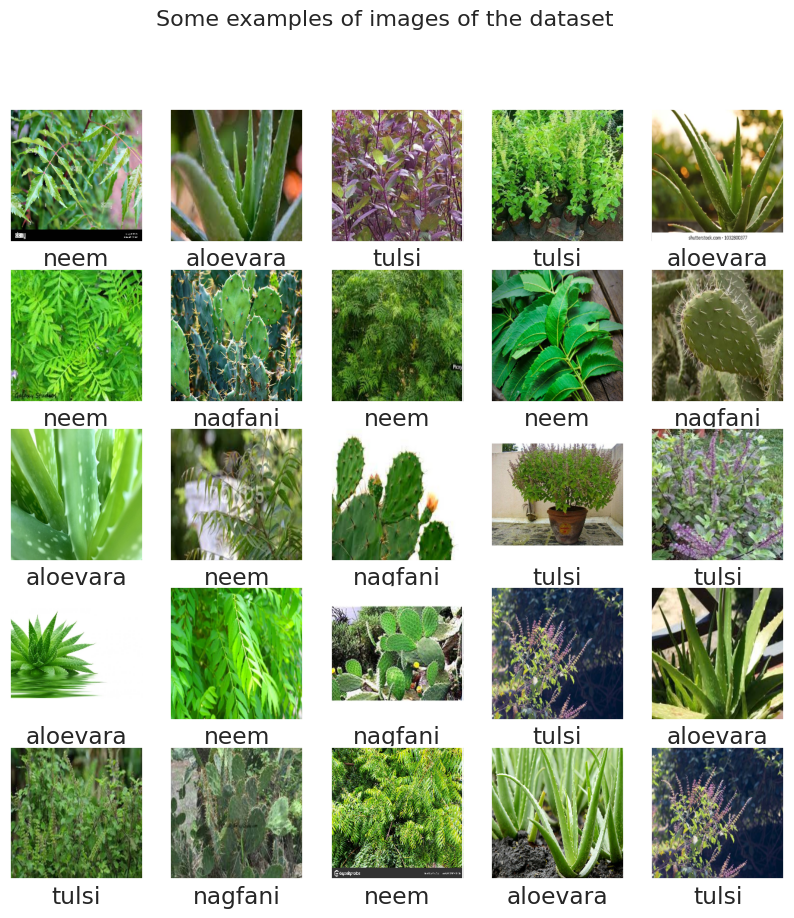

In [73]:
display_examples(class_names, train_images, train_labels)


## Model Creation

### EfficientNetB7 is used as a feature extractor (include_top=False removes the default classification head).
### Global Average Pooling (pooling='avg') reduces the feature map dimensions.
### Dense layers are added for classification, similar to your existing model.

In [74]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras import layers, models

# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

# # Freeze base model layers
# base_model.trainable = False  

# model = models.Sequential([
#     base_model,
#     layers.Dense(128, activation='relu'),
#     layers.Dense(4, activation='softmax')
# ])

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')

# Freeze base model layers
base_model.trainable = False  

model = models.Sequential([
    base_model,
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


## Convolutional Neural Network (CNN).

### 2-layer CNN classifier
### Basic CNN with 2 Conv2D + MaxPooling layers

In [75]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(224,224,3)), 
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dense(4, activation=tf.nn.softmax)
# ])


In [76]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
import PIL.ImageOps as ImageOps
import PIL.Image as Image
from tqdm import tqdm

In [77]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=20, validation_split = 0.2)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4028 - loss: 1.4894 - val_accuracy: 0.6667 - val_loss: 0.9807
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8264 - loss: 0.5591 - val_accuracy: 0.7778 - val_loss: 0.6000
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9815 - loss: 0.2041 - val_accuracy: 0.8889 - val_loss: 0.5570
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9711 - loss: 0.1229 - val_accuracy: 0.8889 - val_loss: 0.4957
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0665 - val_accuracy: 0.8889 - val_loss: 0.4524
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0420 - val_accuracy: 0.8889 - val_loss: 0.4227
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 0.8889 - val_loss: 0.4120
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 0.7778 - val_loss: 0.4115
E

In [79]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

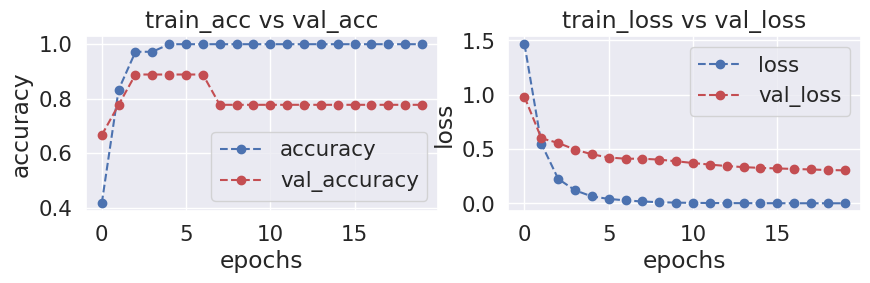

In [80]:
plot_accuracy_loss(history)

In [81]:
test_loss = model.evaluate(test_images, test_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9167 - loss: 0.2345


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


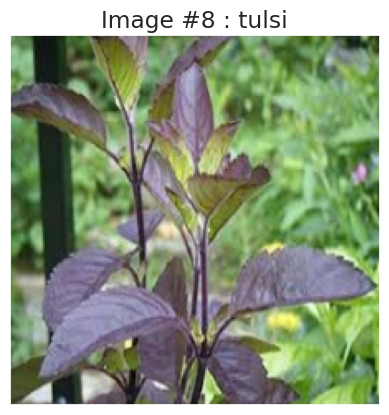

In [82]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [83]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Save as a single HDF5 file
model.save("model.h5")
# model = tf.keras.models.load_model("model.h5")

class_names = list(class_names_label.keys())

def preprocess_single_image(image_path):
    IMAGE_SIZE = (224, 224)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img_norm = img.astype('float32') / 255.0
    img_norm = np.expand_dims(img_norm, axis=0)
    return img, img_norm


def predict_and_display_image(image_path):
    img, img_norm = preprocess_single_image(image_path)
    predictions = model.predict(img_norm)
    predicted_class = np.argmax(predictions, axis=1)[0]
    print(predicted_class)
    class_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

   
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_label}\nConfidence: {confidence:.2f}%", fontsize=14, fontweight="bold")
    plt.show()




In [84]:
#predicted_class

In [85]:

image_path = "imagedataset/train/nagfani/41k2TY3e5AL.jpg"
predict_and_display_image(image_path)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
